In [ ]:
!unzip /content/Agricultural_Image_Analytics-1.zip -d /content/extracted_files

Archive:  /content/Agricultural_Image_Analytics-1.zip
   creating: /content/extracted_files/AgandBio/
  inflating: /content/extracted_files/__MACOSX/._AgandBio  
  inflating: /content/extracted_files/AgandBio/.DS_Store  
  inflating: /content/extracted_files/__MACOSX/AgandBio/._.DS_Store  
   creating: /content/extracted_files/AgandBio/leaves/
  inflating: /content/extracted_files/__MACOSX/AgandBio/._leaves  
  inflating: /content/extracted_files/AgandBio/2.JPG  
  inflating: /content/extracted_files/__MACOSX/AgandBio/._2.JPG  
  inflating: /content/extracted_files/AgandBio/3.JPG  
  inflating: /content/extracted_files/__MACOSX/AgandBio/._3.JPG  
  inflating: /content/extracted_files/AgandBio/1.JPG  
  inflating: /content/extracted_files/__MACOSX/AgandBio/._1.JPG  
  inflating: /content/extracted_files/AgandBio/leaves/I8.png  
  inflating: /content/extracted_files/__MACOSX/AgandBio/leaves/._I8.png  
  inflating: /content/extracted_files/AgandBio/leaves/I1.png  
  inflating: /content/ex

# ***Objective:1***

## generate 100 images


In [ ]:
import os
import cv2
import numpy as np
import random

def random_rotation(image):
    """ Rotate the image by a random angle between -30 and 30 degrees. """
    angle = random.uniform(-30, 30)
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def random_shift(image):
    """ Shift the image randomly along x and y axes. """
    h, w = image.shape[:2]
    max_shift_x = w // 4
    max_shift_y = h // 4
    tx = random.randint(-max_shift_x, max_shift_x)
    ty = random.randint(-max_shift_y, max_shift_y)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    shifted = cv2.warpAffine(image, M, (w, h))
    return shifted

def random_scaling(image):
    """ Scale the image randomly within a given range. """
    scale = random.uniform(0.8, 1.2)
    h, w = image.shape[:2]
    resized = cv2.resize(image, (int(w * scale), int(h * scale)))
    return resized

def random_warp(image):
    """ Apply a random perspective transformation (warp). """
    h, w = image.shape[:2]
    src_pts = np.float32([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])
    dst_pts = np.float32([
        [random.randint(0, w//4), random.randint(0, h//4)],
        [random.randint(3*w//4, w-1), random.randint(0, h//4)],
        [random.randint(0, w//4), random.randint(3*h//4, h-1)],
        [random.randint(3*w//4, w-1), random.randint(3*h//4, h-1)]
    ])
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(image, M, (w, h))
    return warped

def augment_and_save_images(input_folder, output_folder, num_augmented=100):
    """ Perform random transformations on images and save augmented images. """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for img_file in image_files:
        img_path = os.path.join(input_folder, img_file)
        image = cv2.imread(img_path)

        if image is None:
            print(f"Error loading image: {img_file}")
            continue

        for i in range(num_augmented):
            transformed = image.copy()

            if random.random() > 0.5:
                transformed = random_rotation(transformed)
            if random.random() > 0.5:
                transformed = random_shift(transformed)
            if random.random() > 0.5:
                transformed = random_scaling(transformed)
            if random.random() > 0.5:
                transformed = random_warp(transformed)

            output_filename = f"{os.path.splitext(img_file)[0]}_aug_{i}.png"
            output_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_path, transformed)

    print(f"Augmented images saved in {output_folder}")

# Example usage
input_directory = "/content/extracted_files/AgandBio/leaves"
output_directory = "/content/extracted_files/AgandBio/augmented_leaves"

augment_and_save_images(input_directory, output_directory)


Augmented images saved in /content/extracted_files/AgandBio/augmented_leaves


In [ ]:
# !rm -r /content/extracted_files/AgandBio/augmented_leaves/*
# !rm -r /content/extracted_files/AgandBio/leaf_patches/*

In [ ]:
# !ls /content/extracted_files/AgandBio/augmented_leaves | wc
# !ls /content/extracted_files/AgandBio/leaf_patches | wc
# !ls /content/extracted_files/AgandBio/prewhitened_patches/ | wc

## extract local patches of a fixed size

In [ ]:
import os
import cv2
import numpy as np
import random

def extract_patches(image, patch_size=(64, 64), num_patches=10):
    """
    Extracts random patches from an image.

    :param image: Input image (numpy array).
    :param patch_size: Tuple (height, width) of the patch size.
    :param num_patches: Number of patches to extract from each image.
    :return: List of extracted patches.
    """
    h, w = image.shape[:2]
    patch_h, patch_w = patch_size
    patches = []

    for _ in range(num_patches):
        if h <= patch_h or w <= patch_w:
            print("Image is too small for the given patch size.")
            return []

        # Random top-left corner
        x = random.randint(0, w - patch_w)
        y = random.randint(0, h - patch_h)

        patch = image[y:y + patch_h, x:x + patch_w]
        patches.append(patch)

    return patches

def process_images(input_folder, output_folder, patch_size=(64, 64), num_patches=10):
    """
    Extracts patches from all images in a directory and saves them.

    :param input_folder: Directory containing leaf images.
    :param output_folder: Directory to save patches.
    :param patch_size: Size of the patches to extract.
    :param num_patches: Number of patches per image.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for img_file in image_files:
        img_path = os.path.join(input_folder, img_file)
        image = cv2.imread(img_path)

        if image is None:
            print(f"Error loading image: {img_file}")
            continue

        patches = extract_patches(image, patch_size, num_patches)

        for i, patch in enumerate(patches):
            output_filename = f"{os.path.splitext(img_file)[0]}_patch_{i}.png"
            output_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_path, patch)

    print(f"Patches saved in {output_folder}")

# Example usage
input_directory = "/content/extracted_files/AgandBio/augmented_leaves"
output_directory = "/content/extracted_files/AgandBio/leaf_patches"

process_images(input_directory, output_directory, patch_size=(64, 64), num_patches=1)


Patches saved in /content/extracted_files/AgandBio/leaf_patches


## Prewhiten (using ZCA whitening) the patches.

In [ ]:
import os
import numpy as np
import cv2

def compute_zca_whitening_matrix(X):
    """
    Computes the ZCA whitening matrix.

    :param X: Data matrix where each row is a flattened image patch.
    :return: ZCA whitening matrix and mean of X.
    """
    # Compute mean
    mean = np.mean(X, axis=0)
    X_centered = X - mean

    # Compute covariance matrix
    cov = np.cov(X_centered, rowvar=False)

    # Eigen decomposition
    U, S, V = np.linalg.svd(cov)

    # Compute the ZCA whitening matrix
    epsilon = 1e-5  # Small constant to avoid division by zero
    ZCA_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))

    return ZCA_matrix, mean

def apply_zca_whitening(X, ZCA_matrix, mean):
    """
    Applies ZCA whitening to the data.

    :param X: Data matrix where each row is a flattened image patch.
    :param ZCA_matrix: Precomputed ZCA whitening matrix.
    :param mean: Mean used for centering.
    :return: Whitened data matrix.
    """
    X_centered = X - mean
    return np.dot(X_centered, ZCA_matrix.T)

def load_patches(input_folder, patch_size=(64, 64)):
    """
    Loads patches and flattens them into a matrix.

    :param input_folder: Directory containing image patches.
    :param patch_size: Tuple of patch height and width.
    :return: Flattened patch matrix and original shape.
    """
    patch_files = [f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    patches = []

    for patch_file in patch_files:
        patch_path = os.path.join(input_folder, patch_file)
        patch = cv2.imread(patch_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        patch = cv2.resize(patch, patch_size)  # Ensure fixed size
        patches.append(patch.flatten())

    return np.array(patches), patch_files, patch_size

def save_whitened_patches(whitened_patches, patch_files, output_folder, patch_size):
    """
    Saves the ZCA whitened patches as images.

    :param whitened_patches: Numpy array of whitened patches.
    :param patch_files: List of patch filenames.
    :param output_folder: Directory to save whitened patches.
    :param patch_size: Tuple of patch dimensions.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, patch in enumerate(whitened_patches):
        reshaped_patch = patch.reshape(patch_size)
        reshaped_patch = cv2.normalize(reshaped_patch, None, 0, 255, cv2.NORM_MINMAX)
        output_path = os.path.join(output_folder, patch_files[i])
        cv2.imwrite(output_path, reshaped_patch)

    print(f"Whitened patches saved in {output_folder}")

# Directories
input_patch_dir = "/content/extracted_files/AgandBio/leaf_patches"
output_patch_dir = "/content/extracted_files/AgandBio/prewhitened_patches"

# Load patches
patch_matrix, patch_filenames, patch_size = load_patches(input_patch_dir, patch_size=(64, 64))


# Compute ZCA whitening
zca_matrix, mean_vector = compute_zca_whitening_matrix(patch_matrix)

# Apply whitening
whitened_patches = apply_zca_whitening(patch_matrix, zca_matrix, mean_vector)

# Save whitened patches
save_whitened_patches(whitened_patches, patch_filenames, output_patch_dir, patch_size)


Whitened patches saved in /content/extracted_files/AgandBio/prewhitened_patches


Mean Pixel Intensity: 125.1769775390625
Standard Deviation: 35.02927979371943


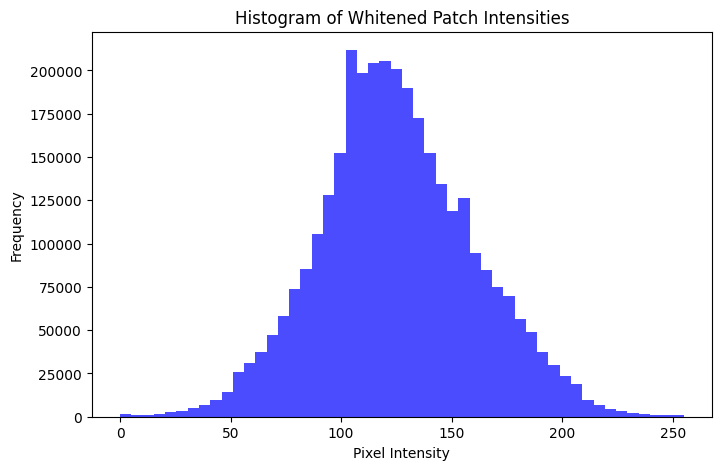

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_whitened_patches(input_folder):
    """
    Load all whitened patches as grayscale images and store them in a list.

    :param input_folder: Directory containing whitened patches.
    :return: List of loaded images.
    """
    patch_files = [f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    patches = []

    for patch_file in patch_files:
        patch_path = os.path.join(input_folder, patch_file)
        patch = cv2.imread(patch_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if patch is not None:
            patches.append(patch)

    return np.array(patches)

def compute_statistics(patches):
    """
    Compute channel-wise distribution statistics (mean, std).

    :param patches: Numpy array of grayscale image patches.
    :return: Dictionary with mean and std of pixel intensities.
    """
    all_pixels = patches.flatten()
    mean_val = np.mean(all_pixels)
    std_val = np.std(all_pixels)

    return {"mean": mean_val, "std": std_val}

def plot_histogram(patches):
    """
    Plot histogram of pixel intensities.

    :param patches: Numpy array of grayscale image patches.
    """
    all_pixels = patches.flatten()

    plt.figure(figsize=(8, 5))
    plt.hist(all_pixels, bins=50, color="blue", alpha=0.7)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Histogram of Whitened Patch Intensities")
    plt.show()

# Directory containing whitened patches
whitened_patch_dir = "/content/extracted_files/AgandBio/prewhitened_patches"

# Load whitened patches
whitened_patches = load_whitened_patches(whitened_patch_dir)

# Compute statistics
stats = compute_statistics(whitened_patches)
print(f"Mean Pixel Intensity: {stats['mean']}")
print(f"Standard Deviation: {stats['std']}")

# Plot histogram
plot_histogram(whitened_patches)


Red Channel - Mean: 65.61666679382324, Std: 40.161086966805534
Green Channel - Mean: 82.29992485046387, Std: 48.53555415770736
Blue Channel - Mean: 57.47348976135254, Std: 33.014074605147485


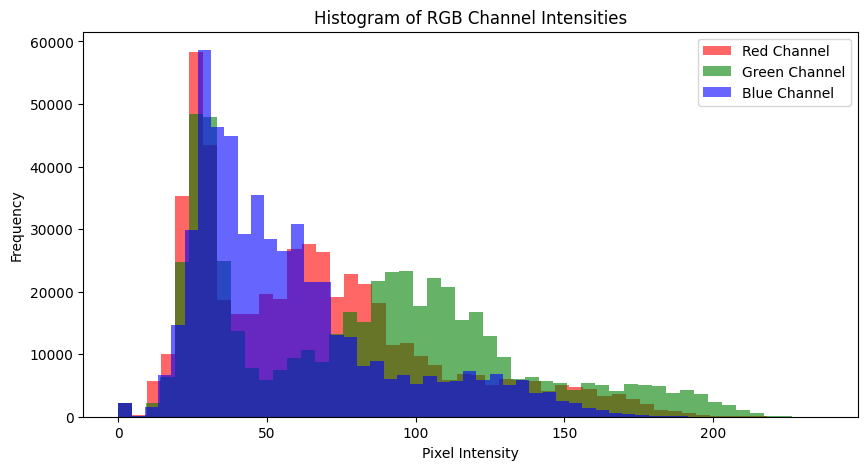

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_original_images(input_folder, resize_shape=(256, 256)):
    """
    Load all original leaf images as RGB and resize them to a fixed shape.

    :param input_folder: Directory containing original leaf images.
    :param resize_shape: Tuple (height, width) to resize images.
    :return: Numpy array of images with the same shape.
    """
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    images = []

    for img_file in image_files:
        img_path = os.path.join(input_folder, img_file)
        image = cv2.imread(img_path)  # Load in BGR format
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            image = cv2.resize(image, resize_shape)  # Resize to a fixed shape
            images.append(image)

    return np.array(images)

def compute_channel_statistics(images):
    """
    Compute channel-wise distribution statistics (mean, std) for RGB channels.

    :param images: Numpy array of RGB images.
    :return: Dictionary with mean and std for each channel.
    """
    all_pixels = images.reshape(-1, 3)  # Flatten to (num_pixels, 3)
    mean_vals = np.mean(all_pixels, axis=0)
    std_vals = np.std(all_pixels, axis=0)

    return {"R_mean": mean_vals[0], "G_mean": mean_vals[1], "B_mean": mean_vals[2],
            "R_std": std_vals[0], "G_std": std_vals[1], "B_std": std_vals[2]}

def plot_channel_histograms(images):
    """
    Plot histograms for each color channel (RGB).

    :param images: Numpy array of RGB images.
    """
    all_pixels = images.reshape(-1, 3)  # Flatten to (num_pixels, 3)

    colors = ["red", "green", "blue"]
    labels = ["Red Channel", "Green Channel", "Blue Channel"]

    plt.figure(figsize=(10, 5))
    for i in range(3):
        plt.hist(all_pixels[:, i], bins=50, color=colors[i], alpha=0.6, label=labels[i])

    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Histogram of RGB Channel Intensities")
    plt.legend()
    plt.show()

# Directory containing original leaf images
original_image_dir = "/content/extracted_files/AgandBio/leaves"

# Load original images
original_images = load_original_images(original_image_dir, resize_shape=(256, 256))

# Compute statistics
original_stats = compute_channel_statistics(original_images)
print(f"Red Channel - Mean: {original_stats['R_mean']}, Std: {original_stats['R_std']}")
print(f"Green Channel - Mean: {original_stats['G_mean']}, Std: {original_stats['G_std']}")
print(f"Blue Channel - Mean: {original_stats['B_mean']}, Std: {original_stats['B_std']}")

# Plot histograms
plot_channel_histograms(original_images)


# ***Objective:2***

In [ ]:
answer_imgs = []

In [ ]:
image_paths = [
    "/content/extracted_files/AgandBio/1.JPG",
    "/content/extracted_files/AgandBio/2.JPG",
    "/content/extracted_files/AgandBio/3.JPG"
]

image_idx = 2

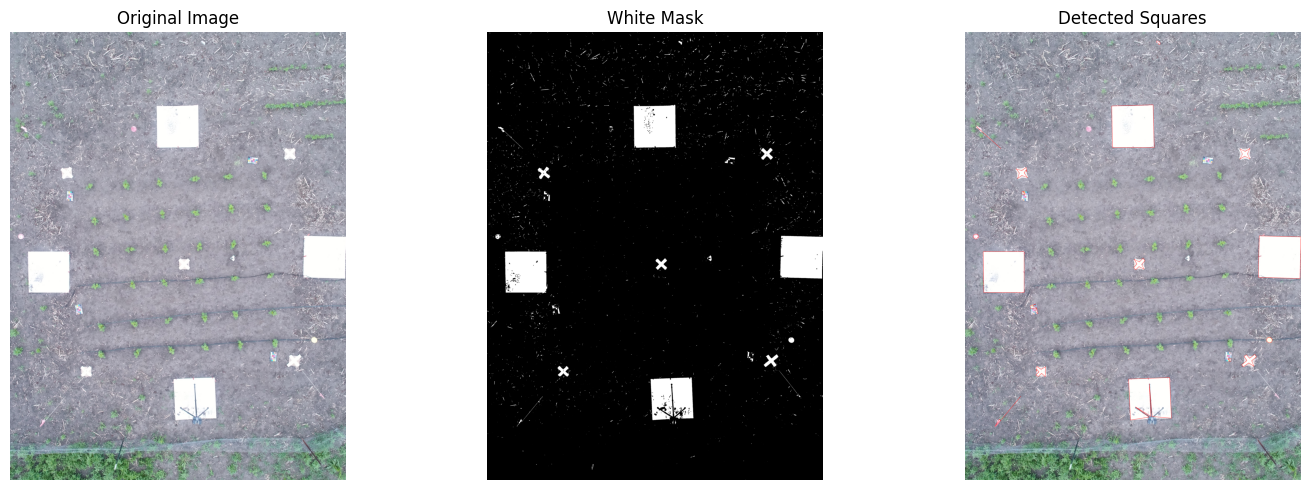

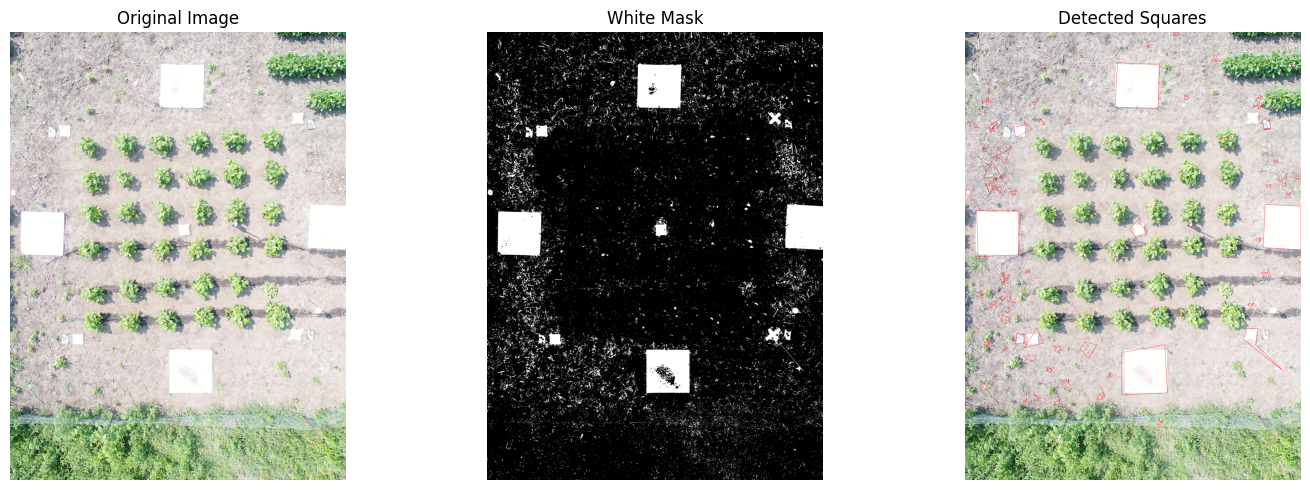

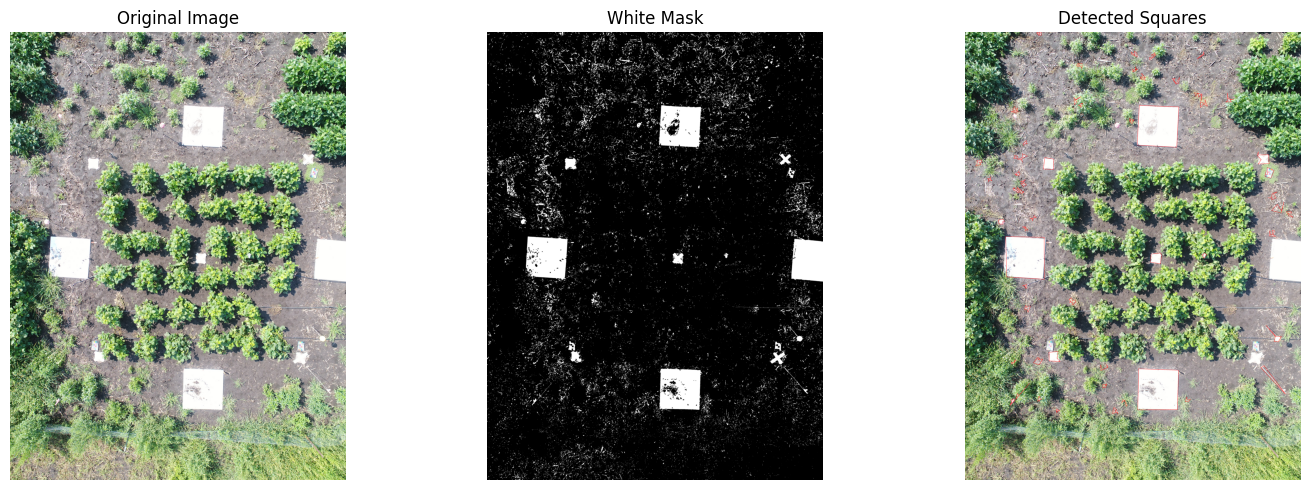

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# (Optional) display images inline in a Jupyter notebook
# %matplotlib inline



def crop_out_squares(image_path):
    # Read the input image
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise IOError("Could not read the image. Check the file path.")

    # Convert BGR to RGB for display with matplotlib
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Convert to HSV for thresholding
    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # Define lower/upper bounds for "white" in HSV
    # Adjust these as needed based on your image
    lower_white = np.array([0, 0, 255], dtype=np.uint8)
    upper_white = np.array([179, 40, 255], dtype=np.uint8)

    # Threshold the image to get only white regions
    mask = cv2.inRange(hsv, lower_white, upper_white)

    # Optional: perform a morphological "close" to fill holes in the white regions
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Find external contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy for drawing the results
    output_bgr = image_bgr.copy()

    # Loop through contours and look for square-like shapes
    for cnt in contours:
        # Approximate contour to reduce the number of points
        epsilon = 0.03 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        # Check if the approximated contour has 4 points => candidate for square/rectangle
        if len(approx) > 0:
            area = cv2.contourArea(cnt)
            if area > 500:  # Filter out small contours; adjust as needed
                # Check aspect ratio
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = float(w) / h

                # Example: accept near-1 aspect ratios for squares
                if 0.8 < aspect_ratio < 1.25:
                    cv2.drawContours(output_bgr, [approx], -1, (0, 0, 255), 2)

    # Convert output from BGR to RGB for displaying in matplotlib
    output_rgb = cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB)

    return image_rgb, mask, output_rgb



for path in image_paths:
    image_rgb, mask, output_rgb = crop_out_squares(path)

    # Display using matplotlib
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("White Mask")
    axes[1].axis('off')

    axes[2].imshow(output_rgb)
    axes[2].set_title("Detected Squares")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

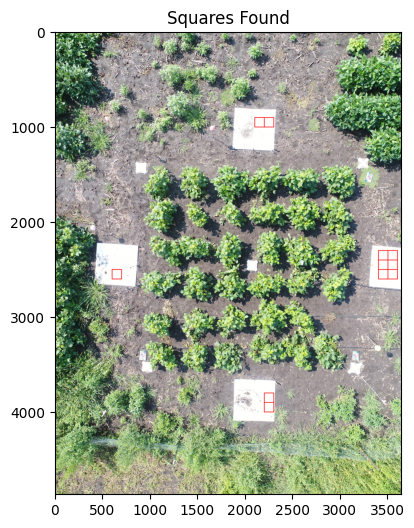

In [ ]:
import cv2
import numpy as np

def scan_left_to_right(mask, kernel_size=100, step=3):
    """
    Scans the mask from left to right (top to bottom) with a kernel of given size.
    When a 100x100 region is fully white, record (row, col) as the square's top-left.
    Skip horizontally by kernel_size after a find, else move in 'step' increments.
    Returns a list of (row, col) locations.
    """
    h, w = mask.shape
    locations = []

    row = 0
    while row <= h - kernel_size:
        col = 1800
        while col <= 2400:
            roi = mask[row:row + kernel_size, col:col + kernel_size]
            if np.all(roi == 255):
                locations.append((row, col))
                # Skip past this square
                col += kernel_size
            else:
                col += step
        row += step
    return locations

def scan_top_to_bottom(mask, kernel_size=100, step=1):
    """
    Scans the mask from top to bottom (left to right) with a kernel of given size.
    When a 100x100 region is fully white, record (row, col) as the square's top-left.
    Skip vertically by kernel_size after a find, else move in 'step' increments.
    Returns a list of (row, col) locations.
    """
    h, w = mask.shape
    locations = []

    col = 0
    while col <= w - kernel_size:
        row = 2100
        while row <= 2700:
            roi = mask[row:row + kernel_size, col:col + kernel_size]
            if np.all(roi == 255):
                locations.append((row, col))
                # Skip past this square
                row += kernel_size
            else:
                row += step
        col += step
    return locations


# Load a binary mask (0 or 255)
image_rgb, mask, output_rgb = crop_out_squares(image_paths[image_idx])

# If the mask is not already binary, threshold it
_, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

# Find all 100x100 squares
squares_lr = scan_left_to_right(mask_bin, kernel_size=100, step=100)
squares_tb = scan_top_to_bottom(mask_bin, kernel_size=100, step=100)

# # Print the results
# print("Found squares at:", squares_tb)

demo_img = image_rgb.copy()
for (r, c) in squares_tb:
    cv2.rectangle(demo_img, (c, r), (c + 100, r + 100), (255, 0, 0), 5)
for (r, c) in squares_lr:
    cv2.rectangle(demo_img, (c, r), (c + 100, r + 100), (255, 0, 0), 5)

# Display using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(demo_img)
plt.title("Squares Found")
plt.show()


Left: 600 Top: 900 Right: 3500 Bottom: 3900


(np.float64(-0.5), np.float64(3647.5), np.float64(4863.5), np.float64(-0.5))

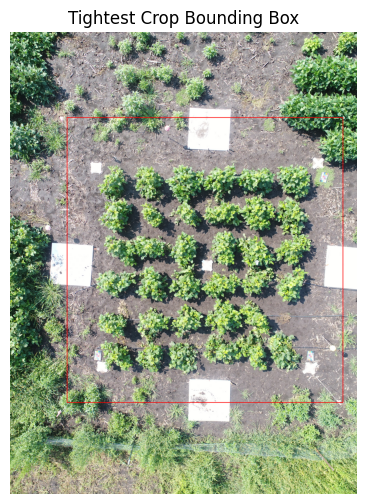

In [ ]:
def find_tightest_crop(lr_locations, tb_locations, img_width, img_height, kernel_size=100):
    """
    Given two sets of locations from left-right and top-bottom scans,
    compute a bounding box defined by:
        - right-most x in the left half
        - left-most x in the right half
        - bottom-most y in the top half
        - top-most y in the bottom half

    Returns (left, top, right, bottom) for the tightest crop.
    """
    w_mid = img_width // 2
    h_mid = img_height // 2

    # lr_locations are (row, col) from left-to-right scanning
    # We only care about col for left vs right half
    left_half = [col for (row, col) in lr_locations if col < w_mid]
    right_half = [col for (row, col) in lr_locations if col >= w_mid]

    # tb_locations are (row, col) from top-to-bottom scanning
    # We only care about row for top vs bottom half
    top_half = [row for (row, col) in tb_locations if row < h_mid]
    bottom_half = [row for (row, col) in tb_locations if row >= h_mid]

    # Find right-most x in left half (max col in left half)
    # If none found, set a default (e.g., 0)
    if len(left_half) > 0:
        x_left_crop = max(left_half)
    else:
        x_left_crop = 0

    # Find left-most x in right half (min col in right half)
    # If none found, set a default (e.g., w_mid or w_mid-kernel_size)
    if len(right_half) > 0:
        x_right_crop = min(right_half) + kernel_size
    else:
        x_right_crop = img_width

    # Find bottom-most y in top half (max row in top half)
    # If none found, set a default (e.g., 0)
    if len(top_half) > 0:
        y_top_crop = max(top_half)
    else:
        y_top_crop = 0

    # Find top-most y in bottom half (min row in bottom half)
    # If none found, set a default
    if len(bottom_half) > 0:
        y_bottom_crop = min(bottom_half) + kernel_size
    else:
        y_bottom_crop = img_height

    return (x_left_crop, y_top_crop, x_right_crop, y_bottom_crop)

# Step 3: Determine tightest crop
(x_left_crop, y_top_crop, x_right_crop, y_bottom_crop) = find_tightest_crop(
    squares_tb, squares_lr, image_rgb.shape[1], image_rgb.shape[0], kernel_size=100
)

# Print or use the crop
print("Left:", x_left_crop, "Top:", y_top_crop,
        "Right:", x_right_crop, "Bottom:", y_bottom_crop)

demo_img = image_rgb.copy()
cv2.rectangle(demo_img,
                (x_left_crop, y_top_crop),
                (x_right_crop, y_bottom_crop),
                (255, 0, 0), 6)

# Show in matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(demo_img)
plt.title("Tightest Crop Bounding Box")
plt.axis('off')

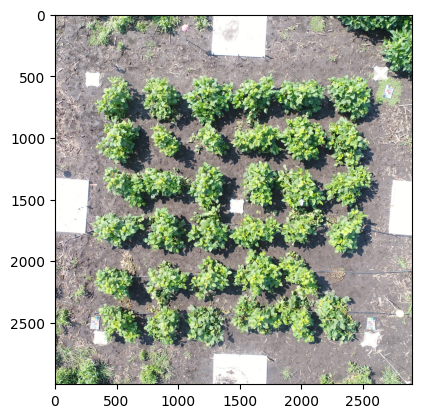

In [ ]:
img = image_rgb[y_top_crop:y_bottom_crop, x_left_crop:x_right_crop,:]
plt.imshow(img)

In [ ]:
def detect_green_plants(image, min_area=1000):
    """Detects and highlights green plants in an image, removing small regions from the mask."""
    # Convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define green color range
    lower_green = np.array([30, 40, 40])
    upper_green = np.array([90, 255, 255])

    # Create mask for green areas
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Remove small components from the mask using connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    filtered_mask = np.zeros_like(mask)

    # Loop over each component and keep only those larger than min_area
    for i in range(1, num_labels):  # skip the background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            filtered_mask[labels == i] = 255

    # Apply the filtered mask to the original image
    result = cv2.bitwise_and(image, image, mask=filtered_mask)

    return image, filtered_mask, result


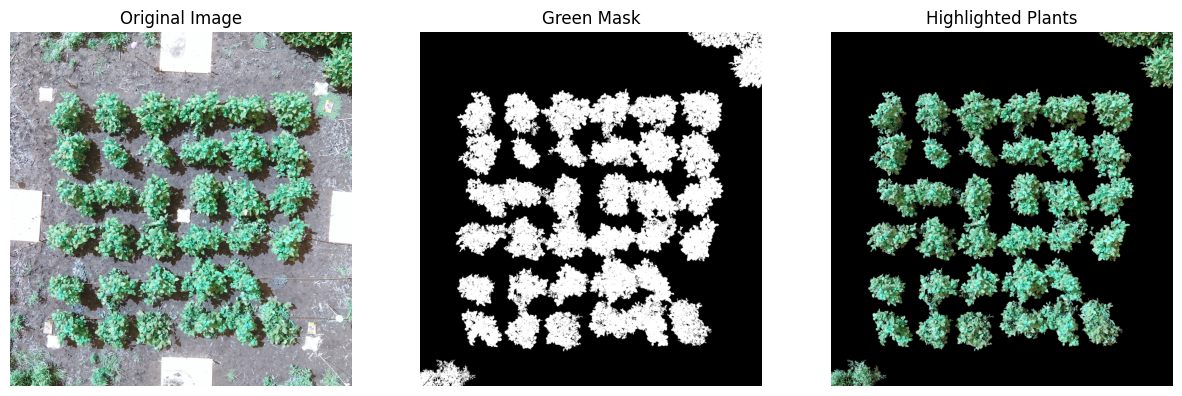

In [ ]:
area_list = (500,3000,50000)
original, mask, highlighted = detect_green_plants(img, min_area=area_list[image_idx]) #min_area = (500,5000,50000) for images 1,2,3 respectively

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Green Mask")
axes[1].axis("off")

axes[2].imshow(highlighted)
axes[2].set_title("Highlighted Plants")
axes[2].axis("off")
plt.show()

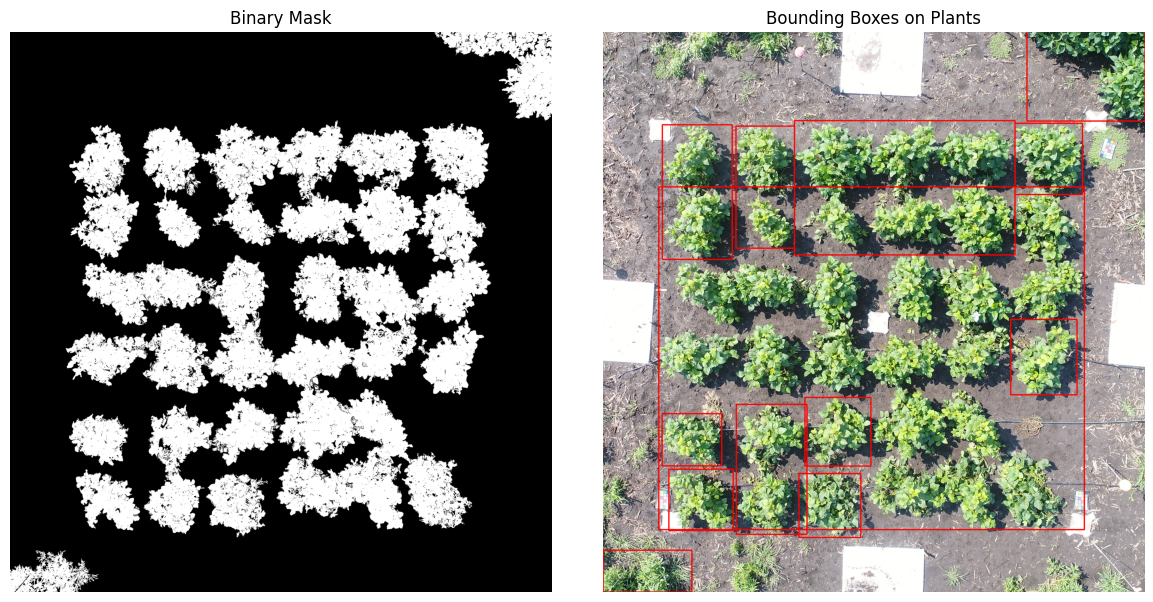

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 'mask' is your binary plant mask (white=plant, black=background).
# 'image' is your cropped region.

# Run connected components with stats
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

# stats[i] gives [x, y, width, height, area] for the i-th connected component
# labels is an image of the same size where each pixel is labeled with its component ID

# Create a copy of the original image for drawing
output = original.copy()

for i in range(1, num_labels):  # start from 1 to skip the background
    x, y, w, h, area = stats[i]

    # Filter out small or large components if needed
    if area < 50:
        continue

    # Draw bounding box
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 5)

# Show results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title('Binary Mask')
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
ax[1].set_title('Bounding Boxes on Plants')
ax[1].axis('off')

plt.tight_layout()
plt.show()
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)


(np.float64(-0.5), np.float64(3647.5), np.float64(4863.5), np.float64(-0.5))

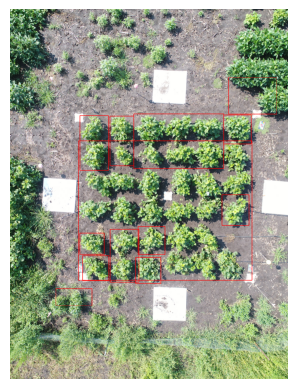

In [ ]:

image_rgb[y_top_crop:y_bottom_crop, x_left_crop:x_right_crop,:] = output
plt.imshow(image_rgb)
plt.axis("off")

In [ ]:
answer_imgs.append(image_rgb)

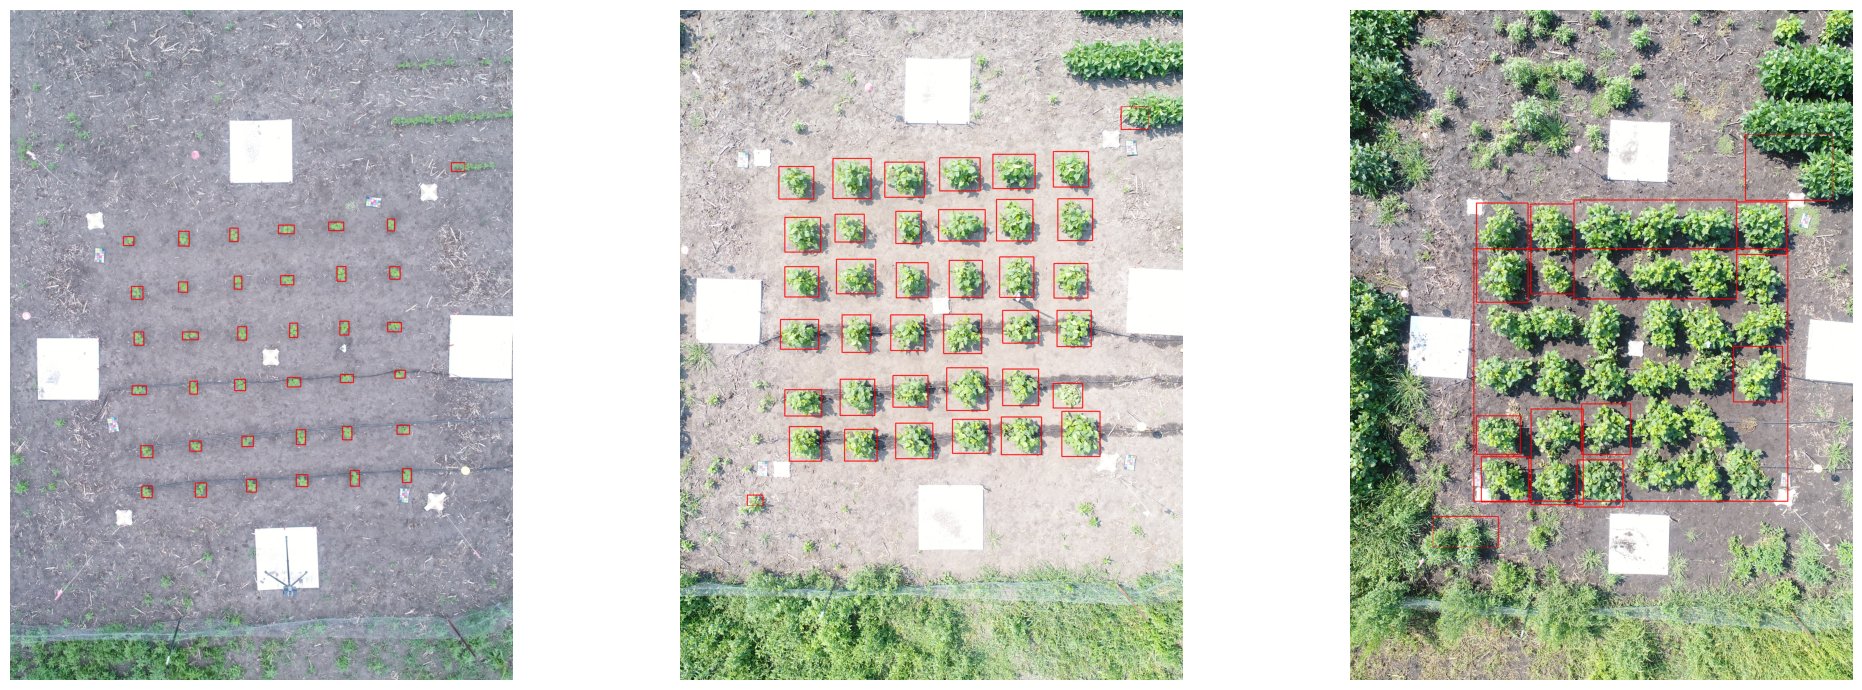

In [ ]:
import matplotlib.pyplot as plt

# Assume `images` is your list of numpy arrays.
num_images = len(answer_imgs)

# Define subplot grid size
cols = min(num_images, 5)  # Up to 5 images per row for better visualization
rows = (num_images + cols - 1) // cols

# Create figure
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 7))

# If only one row, axes might not be a 2D array
if rows == 1:
    axes = [axes]

# Flatten the axes array for easy indexing
axes_flat = [ax for row in axes for ax in (row if isinstance(row, (list, np.ndarray)) else [row])]

for i, ax in enumerate(axes_flat):
    if i < num_images:
        ax.imshow(answer_imgs[i])
        ax.axis('off')  # Remove axis ticks
    else:
        ax.axis('off')  # Hide unused subplots

plt.tight_layout()
plt.show()
